# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
# def sfun(x):
#     return (("Landshut" in str(x['IB Site Name'])) and 
#         (x['OperationalCondition'] != 'Decommissioned') and
#         (x['Engine ID'] == 'M4'))

def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

res = mp.search_installed_fleet(sfun).drop('index', axis=1)
res = res.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
res.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,188.0,185.0,172.0,165.0,180.0,185.0,170.0,157.0,158.0,121.0,157.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
shutdown_counter,136.0,105.0,98.0,99.0,99.0,97.0,91.0,85.0,90.0,82.0,93.0
startup_counter,136.0,103.0,98.0,99.0,98.0,95.0,91.0,85.0,90.0,80.0,88.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [3]:
motor_nummer = 1                    # Index Nummer
e=dmyplant2.Engine.from_fleet(mp,motor:=res.iloc[motor_nummer])
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,Forsa Hartmoor M02,M02,AL87,624,H12,24,4582.1,24.5,1486152,159397,185.0,2022-01-10,54,131,0.119


In [4]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_day=7) #funktioniert nicht
fsm = msgFSM(e, p_from=motor['Commissioning Date'])
fsm.run() # run Finite State Machine

fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

Using '9047 target load reached' Message.


FSM: 100%|████████████████████████| 5623/5623 [00:00<00:00, 11666.02 messages/s]


In [5]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
print(f"""
*****************************************
** {str(res['engine'])} **
*****************************************""")
print(f"{'Meldung':9} '{'9047 target load reached'}' {'gefunden.' if any(res['fsm']._messages['name'] == '9047') else 'wird berechnet.'}")
print(f"{'Zeitraum':9}: {res['fsm'].first_message:%d.%m.%Y} bis {res['fsm'].last_message:%d.%m.%Y}")
print(f"{'Dauer':9}: {res['fsm'].period.days:5} Tage")
print(f"{'GESAMT':9}: {res['result'].shape[0]:5} Starts, {res['result'][res['result'].success].shape[0]:5} erfolgreich => {(res['result'][res['result'].success].shape[0] / res['result'].shape[0]) * 100.0:3.1f} % der Starts erfolgreich.")
for mode in ['???','OFF','MANUAL', 'AUTO']:
    lstarts = res['result'][res['result']['mode'] == mode].shape[0]
    successful_starts = res['result'][((res['result'].success) & (res['result']['mode'] == mode))].shape[0]
    print(f"{mode:9}: {lstarts:5} Starts, {successful_starts:5} erfolgreich => {(successful_starts / lstarts) * 100.0 if lstarts != 0 else 0.0:3.1f} % der Starts erfolgreich.")
#res['filtered_result'][['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));


*****************************************
** 1486152 Forsa Hartmoor M02 **
*****************************************
Meldung   '9047 target load reached' gefunden.
Zeitraum : 10.01.2022 bis 24.02.2022
Dauer    :    45 Tage
GESAMT   :    93 Starts,    63 erfolgreich => 67.7 % der Starts erfolgreich.
???      :     3 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
OFF      :     3 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
MANUAL   :    13 Starts,     0 erfolgreich => 0.0 % der Starts erfolgreich.
AUTO     :    74 Starts,    63 erfolgreich => 85.1 % der Starts erfolgreich.


In [6]:
rdf = res['result']
rdf

,success,mode,starttime,endtime,cumstarttime,alarms,warnings,startpreparation,starter,hochlauf,idle,synchronize,loadramp,targetoperation
0,False,???,2022-01-10 07:19:55.152999936,2022-01-10 07:23:06.796999936,191.644000,[],[],98.271000,3.628999,22.471000,67.272999,NaN,NaN,NaT
1,False,???,2022-01-10 11:03:58.406000128,2022-01-10 11:07:57.500999936,239.094999,[],[],93.909999,3.836000,20.272000,6.355000,69.752000,44.969999,NaT
2,False,???,2022-01-10 11:08:28.972999936,2022-01-10 11:08:33.212000000,4.239000,[],[],4.239000,NaN,NaN,NaN,NaN,NaN,NaT
3,False,MANUAL,2022-01-10 11:09:18.824000000,2022-01-10 11:10:56.833999872,98.009999,[],[],98.009999,NaN,NaN,NaN,NaN,NaN,NaT
4,False,AUTO,2022-01-10 11:10:58.550000128,2022-01-10 11:14:08.936999936,190.386999,[],[],60.638999,4.139000,18.257999,5.649000,55.534999,46.167000,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,True,AUTO,2022-02-19 15:15:05.735000064,2022-02-19 19:33:12.625999872,276.561999,[],[],102.085999,3.736000,19.689000,4.445999,65.485999,81.119000,0 days 04:13:30
89,True,AUTO,2022-02-20 16:15:08.144000000,2022-02-20 21:33:16.094000128,277.024999,[],[],101.267000,4.035000,23.708999,4.838999,48.655000,94.520000,0 days 05:13:31
90,True,AUTO,2022-02-21 17:15:06.376999936,2022-02-21 20:33:11.904999936,276.764000,[],[],102.802000,3.931000,23.398999,4.643000,1.512000,140.476999,0 days 03:13:29
91,True,AUTO,2022-02-22 17:45:07.432999936,2022-02-22 19:33:15.223000064,275.760000,[],[],100.127000,3.740999,23.627000,4.444000,46.842000,96.978999,0 days 01:43:32


In [7]:

# slice results, e.g. [:5] or [80:90] or [100:] etc.
rda = rdf[:].reset_index(drop='index')


# possible modes: ['???','OFF','MANUAL','AUTO']
modes = ['???','OFF','MANUAL','AUTO'] 

# possible modes: [True, False]
success = [False]                  

# count alarms and warnings per cycle
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)

rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')

# special filters can be added like ... 
#rda = rdf[((rdf['synchronize'] < 300.0) & (rdf['startpreparation'] < 300.0))].reset_index(drop='index')
rda = rda[((rda['count_warnings'] > 0) | (rda['count_alarms'] > 0))].reset_index(drop='index')

# display the filterd & selected data
rda[fsm.filter_content + ['count_alarms', 'count_warnings']].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation,count_alarms,count_warnings
0,False,AUTO,30.87,NaN,NaN,NaN,NaN,NaN,30.87,NaT,1,0
1,False,MANUAL,292.02,3.93,24.30,6.05,5.65,396.48,728.45,NaT,0,1
2,False,OFF,4.64,NaN,NaN,NaN,NaN,NaN,4.64,NaT,2,0
3,False,MANUAL,109.05,3.84,22.72,6.08,5.86,232.44,379.99,NaT,0,1
4,False,AUTO,141.33,3.74,17.86,4.04,8.20,153.59,328.77,NaT,0,2


In [8]:
startversuch = rda.iloc[3]; fsm._pre_period = 15
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())
cycle = 1 #sec.
data = fsm.get_period_data(von, bis, cycletime=cycle)
ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von:{von_dt} = {von} bis:{bis_dt} = {bis}")

von:2022-02-17 15:12:56.403000064 = 1645110761 bis:2022-02-17 15:19:16.393999872 = 1645111156


In [9]:
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000)},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
]
dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(16,8))

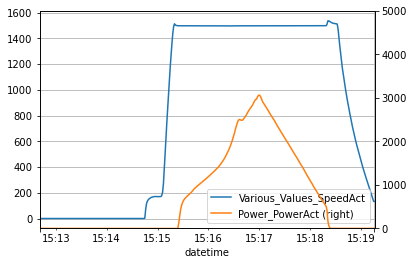

In [10]:
ax, ax2, idf = fsm._plot(data)
plt.show()

In [11]:
ts = int(fsm.first_message.timestamp())
print(ts)
data2 = fsm.get_ts_data(ts, right=43200, cycletime=10)

dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000)},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
]
dmyplant2.dbokeh_chart(data2, dset, title=ftitle, figsize=(16,8))
#Fehler ,wenn eine längere Periode mit derselben Zykluszeit geladen wurde

#ax, ax2, idf = fsm._plot(data2, figsize=(16,10))
#plt.show()

1641775034


In [12]:
idf

,time,Power_PowerAct,Various_Values_SpeedAct,datetime
0,1645110761000,0.0,0.000,2022-02-17 15:12:41
1,1645110762000,0.0,0.000,2022-02-17 15:12:42
2,1645110763000,0.0,0.000,2022-02-17 15:12:43
3,1645110764000,0.0,0.000,2022-02-17 15:12:44
4,1645110765000,0.0,0.000,2022-02-17 15:12:45
...,...,...,...,...
391,1645111152000,0.0,195.315,2022-02-17 15:19:12
392,1645111153000,0.0,175.600,2022-02-17 15:19:13
393,1645111154000,0.0,154.613,2022-02-17 15:19:14
394,1645111155000,0.0,132.917,2022-02-17 15:19:15


In [13]:
lines = startversuch[fsm.vertical_lines_times]
lines

startpreparation       109.052
starter                  3.836
hochlauf                22.715
idle                      6.08
synchronize              5.864
loadramp            232.443999
Name: 3, dtype: object

In [14]:
[lines[:i+1].sum() for i,v in enumerate(lines)]

[109.052, 112.888, 135.603, 141.68300000000002, 147.54700000000003, 379.990999]

In [ ]:
import arrow
def xplot_cycle(rec, max_length=None, cycletime=None, *args, **kwargs):
    t0 = int(arrow.get(rec['starttime']).timestamp() * 1e3 - fsm._pre_period * 1e3)
    t1 = int(arrow.get(rec['endtime']).timestamp() * 1e3)
    if max_length:
        if (t1 - t0) > max_length * 1e3:
            t1 = int(t0 + max_length * 1e3)
    data = fsm.load_data(cycletime, tts_from=t0, tts_to=t1)
    (ax, ax2, idf) = fsm._plot(
        data[
            (data['time'] >= t0) & 
            (data['time'] <= t1)],        
            *args, **kwargs
        )
    return ax,ax2,idf

def org_add_lines(rec, ax):
    duration = 0.0
    for k in rec[fsm.vertical_lines_times].index:
        dtt=rec[k]
        if dtt == dtt:
            ax.axvline(arrow.get(rec['starttime']).shift(seconds=duration).datetime, color="red", linestyle="dotted", label=f"{duration:4.1f}")
            duration = duration + dtt
        else:
            break
    ax.axvline(arrow.get(rec['starttime']).shift(seconds=duration).datetime, color="red", linestyle="dotted", label=f"{duration:4.1f}")

lines = startversuch[fsm.vertical_lines_times]
def add_lines(rec, ax):
    duration = 0.0
    for k in rec[fsm.vertical_lines_times].index:
        dtt=rec[k]
        if dtt == dtt:
            ax.axvline(arrow.get(rec['starttime']).shift(seconds=duration).datetime, color="red", linestyle="dotted", label=f"{duration:4.1f}")
            duration = duration + dtt
        else:
            break
    ax.axvline(arrow.get(rec['starttime']).shift(seconds=duration).datetime, color="red", linestyle="dotted", label=f"{duration:4.1f}")


def add_table(summary, ax, *args, **kwargs):
    """
    available options for loc:
    best, upper right, upper left, lower left, lower right, center left, center right
    lower center, upper center, center, top right,top left, bottom left, bottom right
    right, left, top, bottom
    """
    ax.table(
        cellText=summary.values, 
        colWidths=[0.1]*len(summary.columns),
        colLabels=summary.columns,
        cellLoc='center', 
        rowLoc='center',
        *args, **kwargs)
        #loc='upper left')
    return idf

ax, ax2, idf = xplot_cycle(startversuch, max_length=None, ylim=(0,2500), cycletime=1, style='.-', figsize=(22,12), title=ftitle);
add_lines(startversuch, ax)

summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
add_table(summary, ax, loc='upper left')

plt.show()

In [ ]:
for i,startversuch in rda.iterrows():
    r_summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
    fsm.plot_cycle(startversuch, max_length=None, ylim=(0,2500), cycletime=1, style='.-', figsize=(18,12), 
            title=f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}");
    plt.show();

In [ ]:
rda.describe().round(2).T;

In [ ]:
longer_than_300s = rda[fsm.filter_period + fsm.filter_content][rdf['cumstarttime'] > 300.0]
longer_than_300s[fsm.filter_content].round(2);

In [ ]:
#for i, r in longer_than_300s.iterrows():
#    fsm.plot_cycle(r, max_length=20*60, ylim=(0,5000), title=f"{fsm._e}{r['starttime'].round('S')}: cumstarttime: {r['cumstarttime']}s");

In [ ]:
longer_than_300s.describe().round(2).T;

In [ ]:
load_ramp_less_than_100s = rda[fsm.filter_period + fsm.filter_content][rdf['load-ramp'] < 100.0]
lfsm = load_ramp_less_than_100s[fsm.filter_content].reset_index(drop='index').round(2)
lfsm

In [ ]:
rda.reset_index(drop='index').iloc[10];

In [ ]:
#r = load_ramp_less_than_100s.reset_index(drop='index').iloc[0]
for i in np.arange(0,5):
    r = rda.reset_index(drop='index').iloc[i]
    r_summary = pd.DataFrame(r[fsm.filter_times], dtype=np.float64).round(2).T
    fsm.plot_cycle(r, max_length=20*60, ylim=(0,2500), cycletime=1, marker=None, figsize=(16,10), title=f"{fsm._e} {r['mode']} {r['starttime'].round('S')}");
    plt.show()

In [ ]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['start-preparation','starter','hochlauf','idle','synchronize','cumstarttime','load-ramp','target-operation']].hist(figsize = (20,12), bins=50, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7));
#rda.plot.box(subplots=True, grid = True, figsize=(24,10), layout=(1,7), sym='');

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
phases = [['start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation'],'start-preparation','starter','hochlauf','idle','synchronize','load-ramp','target-operation']
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()